# Imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder

# Load the Data

In [2]:
# Load the data
df = pd.read_csv('Data/tmdb_results_combined.csv.gz', index_col = 'imdb_id')
df.head()

,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0062336,1,0.0,/fw5tsNib4QZBEw18xmebpVe3WZ8.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://poetastros.com/el-tango-del-viudo/,602986.0,es,El tango del viudo y su espejo deformante,...,0.0,63.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,The Tango of the Widower and Its Distorting Mi...,0.0,5.300,3.0,NaN
tt0805647,2,0.0,/8rIoyM6zYXJNjzGseT3MRusMPWl.jpg,NaN,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.thewitchesmovie.net/,531219.0,en,Roald Dahl's The Witches,...,26900000.0,106.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're real!,Roald Dahl's The Witches,0.0,6.435,2315.0,PG
tt0920462,3,0.0,/mwXmcrvjOJwzsJSuNEupjisXUt6.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",https://www.lostgirlslovehotels.film,479259.0,en,Lost Girls & Love Hotels,...,106045.0,97.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Lost Girls & Love Hotels,0.0,5.219,121.0,R
tt0926132,4,0.0,/op14w44FvLUqH7TWyT1ijzrSfXV.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",http://www.roadtored.com,651448.0,en,Darkslide,...,0.0,121.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Keep Moving or Die,Darkslide,0.0,6.500,2.0,NaN


# Data Cleaning

In [3]:
# We will only be using budget, revenue, runtime, and certification for this model
df = df[['budget', 'revenue', 'runtime', 'certification']]
df.head()

,budget,revenue,runtime,certification
imdb_id,,,,
0,NaN,NaN,NaN,NaN
tt0062336,0.0,0.0,63.0,NaN
tt0805647,0.0,26900000.0,106.0,PG
tt0920462,0.0,106045.0,97.0,R
tt0926132,0.0,0.0,121.0,NaN


In [4]:
# Remove any duplicates
df.drop_duplicates(inplace = True)
df.duplicated().sum()

0

In [5]:
# Check for null values
df.isna().sum()

budget              1
revenue             8
runtime             8
certification    5729
dtype: int64

In [6]:
# We will drop the null values in the revenue column
print(df['revenue'].isna().sum() / df.shape[0])
df.dropna(subset = 'revenue', inplace = True)

0.0006008261359369133


In [7]:
# We will drop the null values in the runtime column
print(df['runtime'].isna().sum() / df.shape[0])
df.dropna(subset = 'runtime', inplace = True)

0.0


In [8]:
# Get the percentage of null values in the certification column.
df['certification'].isna().sum() / df.shape[0]

0.42992410009769294

In [9]:
# 43% of the certification values are null so we will impute with 'missing'
df['certification'].fillna('Missing', inplace = True)

In [10]:
# Check the certification column
df['certification'].value_counts()

Missing                            5721
R                                  3213
PG-13                              2133
NR                                 1015
PG                                  884
G                                   235
NC-17                                94
Unrated                               5
Not Rated                             1
UR                                    1
PG-13                                 1
10                                    1
R                                     1
ScreamFest Horror Film Festival       1
-                                     1
Name: certification, dtype: int64

In [11]:
# Fix the unrated labels
df['certification'].replace({'Not Rated': 'NR', 
                             'Unrated': 'NR',
                             'UR': 'NR'},
                            inplace = True)

In [12]:
# Find the issue with R and PG-13 movies
print(df['certification'].str.contains('PG-13 ').sum())
print(df['certification'].str.contains('R ').sum())

1
1


In [13]:
# Fix the ratings with an extra space
df.replace({'PG-13 ': 'PG-13','R ': 'R'}, inplace = True)

In [14]:
# Drop the values in certification that don't seem to make sense
df = df[~df['certification'].str.contains('10')]
df = df[~df['certification'].str.contains('ScreamFest')]

In [15]:
# Drop the column with only '-'
df = df[~(df['certification'] == '-')]

In [16]:
# Check the value counts again
df['certification'].value_counts()

Missing    5721
R          3214
PG-13      2134
NR         1022
PG          884
G           235
NC-17        94
Name: certification, dtype: int64

In [17]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13304 entries, tt0062336 to tt0445841
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   budget         13304 non-null  object 
 1   revenue        13304 non-null  float64
 2   runtime        13304 non-null  float64
 3   certification  13304 non-null  object 
dtypes: float64(2), object(2)
memory usage: 519.7+ KB


In [18]:
# The budget column is not a float.
df['budget'] = df['budget'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13304 entries, tt0062336 to tt0445841
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   budget         13304 non-null  float64
 1   revenue        13304 non-null  float64
 2   runtime        13304 non-null  float64
 3   certification  13304 non-null  object 
dtypes: float64(3), object(1)
memory usage: 519.7+ KB


In [19]:
# See how many values for budget and revenue are 0
filter = (df['budget'] == 0) & (df['revenue'] == 0)
len(df[filter])

771

In [20]:
# Few enough values meet the above condition so we drop those rows
df = df[~filter]

In [21]:
# See how many values for budget or revenue are 0
filter = (df['budget'] == 0) | (df['revenue'] == 0)
len(df[filter]) / df.shape[0]

0.5832601930902418

> 44% of our data is too much to delete. We will keep the rows where either budget or revenue is 0.

# Exploratory Data Analysis

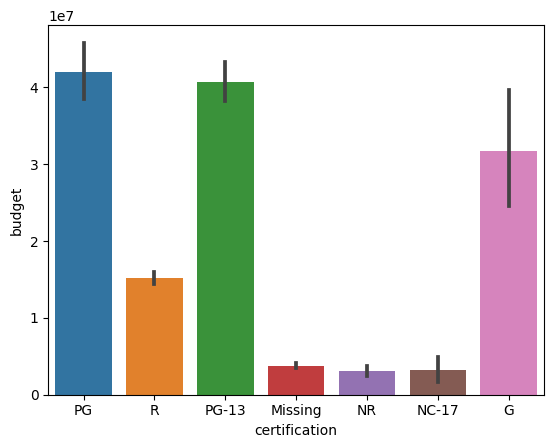

In [22]:
# Construct barplots for budget and certification
sns.barplot(data = df, x = 'certification', y = 'budget');

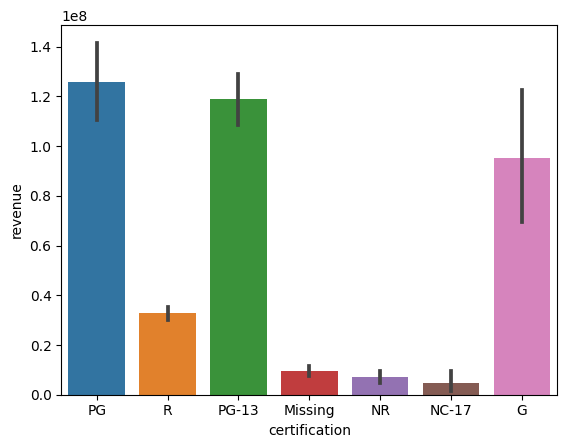

In [23]:
# Construct barplots for revenue and certification
sns.barplot(data = df, x = 'certification', y = 'revenue');

> The shape of these bar plots suggest a correlation between budget and revenue.

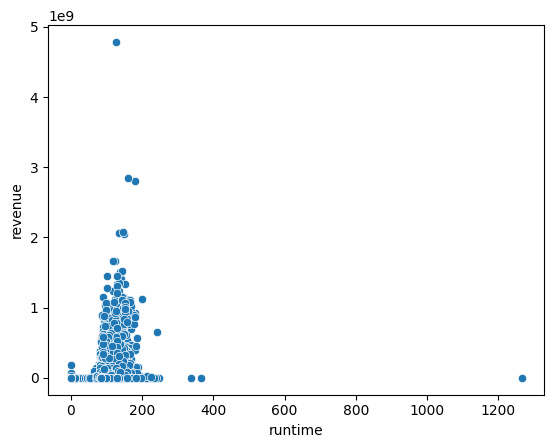

In [24]:
# Construct a scatter plot of revenue vs. runtime
sns.scatterplot(x = df['runtime'], y = df['revenue']);

> There does not appear to be a linear correlation between runtime and revenue, so we will exclude revenue from our model

In [25]:
df.drop(columns = 'runtime', inplace = True)

# Data Preprocessing

In [26]:
# Set the target and features
y = df['revenue'].copy()
X = df.drop(columns = 'revenue').copy()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [31]:
# We will one hot encode the categorical data
cat_selector = make_column_selector(dtype_include = 'object')
cat_cols = cat_selector(df)
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

c# Make a column transformer
col_transformer = make_column_transformer((ohe, cat_cols),
                                          remainder = 'passthrough')
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['certification'])])

In [32]:
# Fit the column transformer
col_transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['certification'])])

In [38]:
# Transform the data
X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)
X_train_processed.shape

(9399, 8)